In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")


In [2]:
son=pd.read_excel("./excel/FiyatPenceresi.Xlsx")
son=son[["Kod","Son.Fyt","Hcm","Yks","Dşk"]]
son.columns=["Hisse","Adj Close","Volume","High","Low"]
son=son.iloc[:-1,:]
son=son.dropna()


In [3]:
hisseler=son["Hisse"].values
hisseler=np.array(hisseler)

In [4]:
directory = 'C:/DATA'
import os
# Boş bir DataFrame oluştur
combined_df = pd.DataFrame()

# Dizindeki tüm JSON dosyalarını oku ve DataFrame'e ekle
for filename in os.listdir(directory):
    if filename.endswith('.json'):
        file_path = os.path.join(directory, filename)
        try:
            df = pd.read_json(file_path)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        except ValueError as e:
            print(f"Error reading {file_path}: {e}")

In [5]:
combined_df["PriceChannel"]=combined_df["PriceChannel"].str[12:].str.upper()
combined_df["Volume"]=combined_df["Amount"]*combined_df["Close"]
combined_df=combined_df.set_index(pd.to_datetime(combined_df["Date"]))
del combined_df["Date"]
del combined_df["Amount"]
combined_df=combined_df[["High","Low","Open","Close","Volume","PriceChannel"]]
combined_df.columns=['High', 'Low', 'Open', 'Adj Close', 'Volume', 'Hisse']
combined_df=combined_df[combined_df["Hisse"].isin(hisseler)]
combined_df = combined_df[~combined_df['Hisse'].isin(['IDEAS', 'ISATR', 'ISKUR', 'ITTFH'])]


In [6]:
combined_df=combined_df.groupby('Hisse').apply(lambda x: x.sort_index(ascending=True))

In [7]:
combined_df=combined_df.droplevel(level=0)

In [8]:
combined_df=combined_df.groupby('Hisse').apply(lambda x: x.sort_index(ascending=True)).droplevel(level=0)

In [9]:
combined_df["Kademe"] = np.where(combined_df["Adj Close"] < 20, 0.01,
                np.where(combined_df["Adj Close"] < 50, 0.02,
                    np.where(combined_df["Adj Close"] < 100, 0.05,
                        np.where(combined_df["Adj Close"] < 250, 0.1,
                            np.where(combined_df["Adj Close"] < 500, 0.25,
                                np.where(combined_df["Adj Close"] < 1000, 0.5,
                                    np.where(combined_df["Adj Close"] < 2500, 1, 2.5)
                                )  # Buradaki parantez eksikti.
                            )
                        )
                    )
                )
            )

In [10]:
combined_df["Tavan"]=((((combined_df["Adj Close"].shift(1))*1.1)/combined_df["Kademe"]).fillna(0).astype(int))*combined_df["Kademe"]
combined_df["Tavan"]=np.round(combined_df["Tavan"],2)

In [11]:
combined_df["Taban"]=((((combined_df["Adj Close"].shift(1))*0.9)//combined_df["Kademe"]).fillna(0).astype(int))*combined_df["Kademe"]
combined_df["Taban"]=np.round(combined_df["Taban"],2)
combined_df["Taban"]=combined_df["Taban"]+combined_df["Kademe"]
combined_df["Taban"]=np.round(combined_df["Taban"],2)

In [12]:
combined_df["Tavan Kontrol"]=np.where((combined_df["Tavan"]==combined_df["Adj Close"]),1,0)
combined_df["Taban Kontrol"]=np.where((combined_df["Taban"]==combined_df["Adj Close"]),1,0)

In [13]:
import pandas_ta as ta

combined_df["SMA 5"]=combined_df["Adj Close"].rolling(5).mean()
combined_df["SMA 10"]=combined_df["Adj Close"].rolling(5).mean()
combined_df["SMA 200"]=combined_df["Adj Close"].rolling(5).mean()

# RSI
combined_df["RSI"] = ta.rsi(combined_df["Adj Close"],14)

# Bağıl Hacim
combined_df["Bağıl Hacim"] = combined_df["Volume"] / combined_df["Volume"].rolling(10).mean()



# ADX, DMI, Aroon
adx_data = ta.adx(combined_df["High"], combined_df["Low"], combined_df["Adj Close"], 14)
combined_df["ADX"], combined_df["DMIP"], combined_df["DMIN"] = adx_data.iloc[:, 0], adx_data.iloc[:, 1], adx_data.iloc[:, 2]




def calculate_stoch_rsi(data, rsi_period=14, stochastic_period=14, k_period=3, d_period=3):
    rsi = ta.rsi(data["Adj Close"], rsi_period)
    stoch_rsi = (rsi - rsi.rolling(window=stochastic_period).min()) / (rsi.rolling(window=stochastic_period).max() - rsi.rolling(window=stochastic_period).min())
    stoch_rsi_k = stoch_rsi.rolling(window=k_period).mean() * 100
    stoch_rsi_d = stoch_rsi_k.rolling(window=d_period).mean()
    data['StochRSI_%K'] = stoch_rsi_k
    data['StochRSI_%D'] = stoch_rsi_d
    return data

combined_df = calculate_stoch_rsi(combined_df)


def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    data['EMA_12'] = ta.ema(data['Adj Close'], short_period)
    data['EMA_26'] = ta.ema(data['Adj Close'], long_period)
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = ta.ema(data['MACD'], signal_period)
    data['MACD_above_Signal'] = (data['MACD'] > data['Signal_Line']).astype(float)
    return data

combined_df = calculate_macd(combined_df)



# Diğer Göstergeler
combined_df["DD"] = ((combined_df["Adj Close"] / combined_df["High"]) - 1) * 100
combined_df["Range"] = ((combined_df["High"] - combined_df["Low"]) / combined_df["Adj Close"]) * 100

combined_df["MOM"] = ta.mom(combined_df["Adj Close"], 10)



combined_df["Driehaus Momentum"] = ((combined_df["Bağıl Hacim"] > 2) & (combined_df["RSI"] > 50) & (combined_df["MOM"] > 1) & (combined_df["Adj Close"] > combined_df["SMA 5"]) & (combined_df["Adj Close"] > combined_df["SMA 10"]) & (combined_df["Adj Close"] > combined_df["SMA 200"])).astype(int)
combined_df["MACD Yukarı Kesen"] = ((combined_df["Bağıl Hacim"] > 1.5) & (combined_df["MACD"] > 0) & (combined_df["MACD_above_Signal"] == 1)).astype(int)
combined_df["ADXDMI20"] = ((combined_df["Bağıl Hacim"] > 1.3) & (combined_df["ADX"] > 20) & (combined_df["DMIP"] > combined_df["DMIN"])).astype(int)
combined_df["MACD+Stoch"] = ((combined_df["Bağıl Hacim"] > 1.3) & (combined_df["StochRSI_%K"] > combined_df["StochRSI_%D"]) & (combined_df["MACD_above_Signal"] == 1)).astype(int)




In [14]:
import pandas_ta as ta
import ta as ta1

combined_df['MACD_Signal'] = combined_df["Signal_Line"]
combined_df['MACD_Diff'] = ta1.trend.macd_diff(combined_df['Adj Close'])
combined_df['ROC'] = ta.roc(combined_df["Adj Close"],12)



In [15]:
combined_df["Return"]=100*((combined_df["Adj Close"]/combined_df["Open"])-1)
combined_df["Return"]=combined_df["Return"].shift(-1)
combined_df["Label"]=np.where(combined_df["Return"]>0,1,0)
combined_df["Date"]=pd.to_datetime(combined_df.index)

combined_df


,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Tavan,Taban,Tavan Kontrol,...,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,MACD_Signal,MACD_Diff,ROC,Return,Label,Date
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.200518e+06,A1CAP,0.02,0.00,0.02,0,...,0,0,0,0,NaN,NaN,NaN,0.000000,0,2023-06-15
2023-06-16,30.24,30.24,30.24,30.24,3.531563e+07,A1CAP,0.02,30.24,24.76,1,...,0,0,0,0,NaN,NaN,NaN,0.000000,0,2023-06-16
2023-06-19,33.26,33.26,33.26,33.26,6.191715e+07,A1CAP,0.02,33.26,27.22,1,...,0,0,0,0,NaN,NaN,NaN,-3.419355,0,2023-06-19
2023-06-20,31.10,29.94,31.00,29.94,2.402000e+08,A1CAP,0.02,36.58,29.94,0,...,0,0,0,0,NaN,NaN,NaN,0.000000,0,2023-06-20
2023-06-21,26.96,26.96,26.96,26.96,5.779965e+07,A1CAP,0.02,32.92,26.96,0,...,0,0,0,0,NaN,NaN,NaN,1.249024,1,2023-06-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-20,7.73,7.42,7.50,7.62,1.793442e+07,ZRGYO,0.01,8.27,6.77,0,...,0,0,0,0,0.116358,-0.032776,-3.422053,5.387648,1,2024-06-20
2024-06-21,8.02,7.59,7.61,8.02,1.542262e+07,ZRGYO,0.01,8.38,6.86,0,...,0,0,0,0,0.116716,0.001433,-1.715686,0.123916,1,2024-06-21
2024-06-24,8.20,7.89,8.07,8.08,3.319590e+07,ZRGYO,0.01,8.82,7.22,0,...,0,0,0,0,0.123107,0.025565,1.507538,-1.970443,0,2024-06-24


In [16]:
endeks=pd.read_json("C:/DATA/imkbx/xu100.json")
endeks=endeks.set_index(pd.to_datetime(endeks["Date"]))
endeks=endeks["Close"]
endeks

Date
2010-01-04      533.68
2010-01-05      541.15
2010-01-06      545.47
2010-01-07      549.73
2010-01-08      547.98
                ...   
2024-06-20    10739.94
2024-06-21    10771.36
2024-06-24    10767.85
2024-06-25    10679.98
2024-06-26    10486.70
Name: Close, Length: 3634, dtype: float64

In [17]:

combined_df["Endeks"]=endeks
combined_df["Endeks Return"]=100*((combined_df["Endeks"]/combined_df["Endeks"].shift(1))-1)
combined_df["Endeks Return Lag"]=100*((combined_df["Endeks"].shift(1)/combined_df["Endeks"].shift(2))-1)
combined_df["Return Lag"]=((combined_df["Adj Close"]/combined_df["Adj Close"].shift(1))-1)*100
combined_df

,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Tavan,Taban,Tavan Kontrol,...,MACD_Signal,MACD_Diff,ROC,Return,Label,Date,Endeks,Endeks Return,Endeks Return Lag,Return Lag
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.200518e+06,A1CAP,0.02,0.00,0.02,0,...,NaN,NaN,NaN,0.000000,0,2023-06-15,5495.48,NaN,NaN,NaN
2023-06-16,30.24,30.24,30.24,30.24,3.531563e+07,A1CAP,0.02,30.24,24.76,1,...,NaN,NaN,NaN,0.000000,0,2023-06-16,5475.48,-0.363935,NaN,9.963636
2023-06-19,33.26,33.26,33.26,33.26,6.191715e+07,A1CAP,0.02,33.26,27.22,1,...,NaN,NaN,NaN,-3.419355,0,2023-06-19,5269.31,-3.765332,-0.363935,9.986772
2023-06-20,31.10,29.94,31.00,29.94,2.402000e+08,A1CAP,0.02,36.58,29.94,0,...,NaN,NaN,NaN,0.000000,0,2023-06-20,5251.61,-0.335907,-3.765332,-9.981960
2023-06-21,26.96,26.96,26.96,26.96,5.779965e+07,A1CAP,0.02,32.92,26.96,0,...,NaN,NaN,NaN,1.249024,1,2023-06-21,5186.83,-1.233526,-0.335907,-9.953240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-20,7.73,7.42,7.50,7.62,1.793442e+07,ZRGYO,0.01,8.27,6.77,0,...,0.116358,-0.032776,-3.422053,5.387648,1,2024-06-20,10739.94,2.565293,0.764346,1.329787
2024-06-21,8.02,7.59,7.61,8.02,1.542262e+07,ZRGYO,0.01,8.38,6.86,0,...,0.116716,0.001433,-1.715686,0.123916,1,2024-06-21,10771.36,0.292553,2.565293,5.249344
2024-06-24,8.20,7.89,8.07,8.08,3.319590e+07,ZRGYO,0.01,8.82,7.22,0,...,0.123107,0.025565,1.507538,-1.970443,0,2024-06-24,10767.85,-0.032586,0.292553,0.748130


In [18]:
combined_df=combined_df.dropna()

In [19]:
combined_df=combined_df.sort_index()

In [20]:
target_data = {
    "2024-02-13": "PATEK.IS",
    "2024-02-15": "BORSK.IS",
    "2024-02-22": "LMKDC.IS",
    "2024-02-29": "ALVES.IS",
    "2024-03-04": "ARTMS.IS",
    "2024-03-05": "MOGAN.IS",
    "2024-03-11": ["BARMA.IS", "INVES.IS", "EDATA.IS"],
    "2024-03-21": "ODINE.IS",
    "2024-04-26": "RGYAS.IS",
    "2024-05-02": ["OBAMS.IS", "ENTRA.IS"],
    "2024-05-09": "LILAK.IS",
    "2024-05-10": "KOTON.IS",
    "2024-05-16": "ALTNY.IS",
    "2024-05-17": "KOCMT.IS",
    "2024-05-23": "HRKET.IS",
    "2024-05-27": "PEHOL.IS",
    "2024-05-28": "ONRYT.IS",
    "2024-05-29": "OZYSR.IS",
    "2024-06-04": "ALKLC.IS",
    "2024-06-06": "YIGIT.IS",
    "2024-06-07": "HOROZ.IS"
}
for date, stocks in target_data.items():
    if isinstance(stocks, list):
        for stock in stocks:
            combined_df.loc[(combined_df.index == date) & (combined_df["Hisse"] == stock), "Tavan Kontrol"] = 1
    else:
        combined_df.loc[(combined_df.index == date) & (combined_df["Hisse"] == stocks), "Tavan Kontrol"] = 1
son=combined_df.loc[combined_df.sort_index().index.unique()[-2:]]
ilk=combined_df.loc[combined_df.sort_index().index.unique()[:-2]]
ilk=ilk[(ilk["Return"]<21) & (ilk["Return"]>-19)]
result=pd.concat([ilk,son],axis=0)

In [21]:


yasak=["YYAPI","EMNIS","TETMT","RODRG","BRKO","AYES","EUKYO","YGYO","BALAT","SONME","SNKRN","KSTUR","DERIM","UZERB","MARKA","MMCAS","YAYLA"]
for i in range(len(yasak)):
    yasak[i]=yasak[i]+".IS"

In [22]:
combined_df=combined_df.sort_index()

yasak=["YYAPI","EMNIS","TETMT","RODRG","BRKO","AYES","EUKYO","YGYO","BALAT","SONME","SNKRN","KSTUR","DERIM","UZERB","MARKA","MMCAS","YAYLA"]
result=result.dropna()
result = result[~result['Hisse'].isin(["ISATR","ISBTR"])]
result = result[~result['Hisse'].isin(yasak)]
result=result[result["Tavan Kontrol"]==0]
result=result.sort_index()


In [25]:
mindates=combined_df.groupby("Hisse")["Date"].min()
arzlar=mindates[mindates>"2023-07-01"].index

In [27]:
val=result.loc["2023-07-01":"2023-12-31"].dropna()
train=result.loc["2017-01-01":"2023-06-30"].dropna()
test=result.loc["2024-01-01":].dropna()
X_train=train[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
X_test=test[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
X_val=val[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
y_train=train["Label"]
y_test=test["Label"]
y_val=val["Label"]

In [30]:
import optuna
import pandas as pd
from catboost import CatBoostRegressor,CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit




def objective(trial):
    # Hyperparameter space
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30)
    }

    model = CatBoostClassifier(**param, verbose=0, random_seed=42, task_type="GPU")



    model.fit(X_train, y_train)

        
    tahminler=pd.DataFrame(val["Return"])
    tahminler=tahminler.set_index(X_val.index)
    tahminler["Tahmin"]=model.predict_proba(X_val)[:,1]
    tahminler.columns=["Gerçek","Tahmin"]
    tahminler["Hisse"]=val["Hisse"]
    tahminler["Tavan"]=val["Tavan Kontrol"]
    tahminler["Taban"]=val["Taban Kontrol"]
    tahminler=tahminler[tahminler["Tavan"]==0]
    tahminler=tahminler[tahminler["Taban"]==0]
    tahminler = tahminler[~tahminler['Hisse'].isin(arzlar)]
    top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
    topkar = (top_5_rows.groupby('Date')["Gerçek"].mean().cumsum() )
    returns = (top_5_rows.groupby('Date')["Gerçek"].mean().cumsum()).diff().dropna()
    pozitif = returns[returns > 0].mean()
    negatif = returns[returns < 0].mean()
    ort = abs(pozitif / negatif)
    print(topkar.iloc[-1])
        

    
    return ort

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print('En iyi parametreler: ', study.best_params)
print('En iyi skor: ', study.best_value)


[I 2024-06-26 23:22:45,315] A new study created in memory with name: no-name-a86d7889-fa2e-4e41-9d71-0fa960ae845d
[I 2024-06-26 23:23:06,075] Trial 0 finished with value: 1.0191317903889137 and parameters: {'iterations': 636, 'depth': 9, 'learning_rate': 0.44942101713158966, 'random_strength': 4, 'bagging_temperature': 0.5401454350565187, 'border_count': 104, 'l2_leaf_reg': 2}. Best is trial 0 with value: 1.0191317903889137.


16.085699327968985


[I 2024-06-26 23:23:15,286] Trial 1 finished with value: 1.4961310391223661 and parameters: {'iterations': 636, 'depth': 4, 'learning_rate': 0.06447222997755124, 'random_strength': 12, 'bagging_temperature': 0.2654649019622325, 'border_count': 215, 'l2_leaf_reg': 12}. Best is trial 1 with value: 1.4961310391223661.


142.12279205976944


[I 2024-06-26 23:23:24,426] Trial 2 finished with value: 1.1289055994667607 and parameters: {'iterations': 354, 'depth': 8, 'learning_rate': 0.04203863748377652, 'random_strength': 3, 'bagging_temperature': 0.9631350732525061, 'border_count': 237, 'l2_leaf_reg': 16}. Best is trial 1 with value: 1.4961310391223661.


102.80661528909631


[I 2024-06-26 23:23:33,687] Trial 3 finished with value: 1.0637959888606021 and parameters: {'iterations': 582, 'depth': 4, 'learning_rate': 0.3304183117397863, 'random_strength': 4, 'bagging_temperature': 0.21830379921967513, 'border_count': 131, 'l2_leaf_reg': 18}. Best is trial 1 with value: 1.4961310391223661.


80.40138070700885


[I 2024-06-26 23:23:38,870] Trial 4 finished with value: 1.3471433336737133 and parameters: {'iterations': 254, 'depth': 5, 'learning_rate': 0.06692646236859147, 'random_strength': 11, 'bagging_temperature': 0.4238906694236865, 'border_count': 90, 'l2_leaf_reg': 21}. Best is trial 1 with value: 1.4961310391223661.


144.57495136438578


[I 2024-06-26 23:23:50,248] Trial 5 finished with value: 1.22872568619933 and parameters: {'iterations': 534, 'depth': 7, 'learning_rate': 0.06429979318886397, 'random_strength': 13, 'bagging_temperature': 0.653794340421501, 'border_count': 103, 'l2_leaf_reg': 16}. Best is trial 1 with value: 1.4961310391223661.


115.78790862005498


[I 2024-06-26 23:23:53,636] Trial 6 finished with value: 1.2385308959748642 and parameters: {'iterations': 162, 'depth': 7, 'learning_rate': 0.13617894350780502, 'random_strength': 12, 'bagging_temperature': 0.8635922908809056, 'border_count': 115, 'l2_leaf_reg': 22}. Best is trial 1 with value: 1.4961310391223661.


94.94195012434847


[I 2024-06-26 23:24:18,689] Trial 7 finished with value: 1.2824682099520857 and parameters: {'iterations': 934, 'depth': 9, 'learning_rate': 0.20944480614346836, 'random_strength': 13, 'bagging_temperature': 0.1334519475643774, 'border_count': 144, 'l2_leaf_reg': 16}. Best is trial 1 with value: 1.4961310391223661.


71.40080822286801


[I 2024-06-26 23:24:34,630] Trial 8 finished with value: 1.2620957635121381 and parameters: {'iterations': 801, 'depth': 7, 'learning_rate': 0.478216726336351, 'random_strength': 9, 'bagging_temperature': 0.47263323768112064, 'border_count': 2, 'l2_leaf_reg': 19}. Best is trial 1 with value: 1.4961310391223661.


34.51793769366744


[I 2024-06-26 23:24:45,222] Trial 9 finished with value: 0.9978025934214283 and parameters: {'iterations': 540, 'depth': 7, 'learning_rate': 0.3093387422382046, 'random_strength': 17, 'bagging_temperature': 0.0391491107629226, 'border_count': 165, 'l2_leaf_reg': 21}. Best is trial 1 with value: 1.4961310391223661.


83.36634995361655


[I 2024-06-26 23:24:57,524] Trial 10 finished with value: 1.3019662045246845 and parameters: {'iterations': 773, 'depth': 5, 'learning_rate': 0.18748606710163787, 'random_strength': 20, 'bagging_temperature': 0.2909172078959288, 'border_count': 235, 'l2_leaf_reg': 7}. Best is trial 1 with value: 1.4961310391223661.


93.97101445543885


[I 2024-06-26 23:25:02,500] Trial 11 finished with value: 1.2469450131598618 and parameters: {'iterations': 306, 'depth': 5, 'learning_rate': 0.1104373414283881, 'random_strength': 8, 'bagging_temperature': 0.37397349509666433, 'border_count': 51, 'l2_leaf_reg': 29}. Best is trial 1 with value: 1.4961310391223661.


139.67995055258032


[I 2024-06-26 23:25:09,417] Trial 12 finished with value: 0.8125006454256881 and parameters: {'iterations': 374, 'depth': 4, 'learning_rate': 0.012945102696046859, 'random_strength': 16, 'bagging_temperature': 0.683112146009518, 'border_count': 200, 'l2_leaf_reg': 10}. Best is trial 1 with value: 1.4961310391223661.


44.255607585342304


[I 2024-06-26 23:25:11,718] Trial 13 finished with value: 1.6422507505427308 and parameters: {'iterations': 106, 'depth': 5, 'learning_rate': 0.12583310316231897, 'random_strength': 7, 'bagging_temperature': 0.405529785384636, 'border_count': 52, 'l2_leaf_reg': 27}. Best is trial 13 with value: 1.6422507505427308.


138.79223365351444


[I 2024-06-26 23:25:14,089] Trial 14 finished with value: 1.2921870422618857 and parameters: {'iterations': 132, 'depth': 6, 'learning_rate': 0.1516007155929775, 'random_strength': 7, 'bagging_temperature': 0.2805552236327058, 'border_count': 54, 'l2_leaf_reg': 29}. Best is trial 13 with value: 1.6422507505427308.


112.19435177016791


[I 2024-06-26 23:25:21,047] Trial 15 finished with value: 1.2185247547769265 and parameters: {'iterations': 472, 'depth': 4, 'learning_rate': 0.24888521686103476, 'random_strength': 6, 'bagging_temperature': 0.5893413297158643, 'border_count': 197, 'l2_leaf_reg': 10}. Best is trial 13 with value: 1.6422507505427308.


89.92750914526594


[I 2024-06-26 23:25:34,587] Trial 16 finished with value: 0.9499105612965403 and parameters: {'iterations': 821, 'depth': 6, 'learning_rate': 0.10094318309760335, 'random_strength': 15, 'bagging_temperature': 0.03303836049823561, 'border_count': 2, 'l2_leaf_reg': 26}. Best is trial 13 with value: 1.6422507505427308.


29.827607718096168


[I 2024-06-26 23:26:06,884] Trial 17 finished with value: 0.9642235916737814 and parameters: {'iterations': 994, 'depth': 10, 'learning_rate': 0.19401807771731527, 'random_strength': 1, 'bagging_temperature': 0.3607507847169469, 'border_count': 54, 'l2_leaf_reg': 11}. Best is trial 13 with value: 1.6422507505427308.


27.381815267426912


[I 2024-06-26 23:26:17,016] Trial 18 finished with value: 1.396084412218871 and parameters: {'iterations': 671, 'depth': 5, 'learning_rate': 0.0958403180751661, 'random_strength': 10, 'bagging_temperature': 0.1686974271659783, 'border_count': 173, 'l2_leaf_reg': 25}. Best is trial 13 with value: 1.6422507505427308.


117.6121932496246


[I 2024-06-26 23:26:25,014] Trial 19 finished with value: 1.1917935794066168 and parameters: {'iterations': 452, 'depth': 6, 'learning_rate': 0.3851668015856199, 'random_strength': 18, 'bagging_temperature': 0.6981280699771729, 'border_count': 255, 'l2_leaf_reg': 13}. Best is trial 13 with value: 1.6422507505427308.


67.98038190573466


[I 2024-06-26 23:26:34,888] Trial 20 finished with value: 1.1892326409188507 and parameters: {'iterations': 706, 'depth': 4, 'learning_rate': 0.25564535521090226, 'random_strength': 14, 'bagging_temperature': 0.7789101863861627, 'border_count': 81, 'l2_leaf_reg': 3}. Best is trial 13 with value: 1.6422507505427308.


82.49021039750326


[I 2024-06-26 23:26:47,627] Trial 21 finished with value: 1.0019063382025728 and parameters: {'iterations': 678, 'depth': 5, 'learning_rate': 0.09640953122577067, 'random_strength': 10, 'bagging_temperature': 0.1722495420524165, 'border_count': 185, 'l2_leaf_reg': 25}. Best is trial 13 with value: 1.6422507505427308.


80.88900594340816


[I 2024-06-26 23:26:57,048] Trial 22 finished with value: 1.0849792281365194 and parameters: {'iterations': 621, 'depth': 5, 'learning_rate': 0.014091349881778917, 'random_strength': 6, 'bagging_temperature': 0.11842663264450673, 'border_count': 153, 'l2_leaf_reg': 25}. Best is trial 13 with value: 1.6422507505427308.


94.70056877614942


[I 2024-06-26 23:27:10,847] Trial 23 finished with value: 1.1547284420714514 and parameters: {'iterations': 865, 'depth': 6, 'learning_rate': 0.14390998741026884, 'random_strength': 10, 'bagging_temperature': 0.2754112148808513, 'border_count': 219, 'l2_leaf_reg': 27}. Best is trial 13 with value: 1.6422507505427308.


80.81449053099044


[I 2024-06-26 23:27:16,942] Trial 24 finished with value: 1.5233902219433129 and parameters: {'iterations': 469, 'depth': 4, 'learning_rate': 0.07235534522313607, 'random_strength': 8, 'bagging_temperature': 0.36741672075850146, 'border_count': 171, 'l2_leaf_reg': 23}. Best is trial 13 with value: 1.6422507505427308.


146.33687147852237


[I 2024-06-26 23:27:20,041] Trial 25 finished with value: 1.500931993805357 and parameters: {'iterations': 200, 'depth': 4, 'learning_rate': 0.0587933438731032, 'random_strength': 8, 'bagging_temperature': 0.4872263251451261, 'border_count': 28, 'l2_leaf_reg': 23}. Best is trial 13 with value: 1.6422507505427308.


165.8707428877278


[I 2024-06-26 23:27:23,374] Trial 26 finished with value: 1.4578168130303197 and parameters: {'iterations': 216, 'depth': 4, 'learning_rate': 0.16311177983204894, 'random_strength': 8, 'bagging_temperature': 0.5024794027375843, 'border_count': 32, 'l2_leaf_reg': 23}. Best is trial 13 with value: 1.6422507505427308.


136.8829085871238


[I 2024-06-26 23:27:25,022] Trial 27 finished with value: 0.9383672113319184 and parameters: {'iterations': 103, 'depth': 4, 'learning_rate': 0.041708758319683556, 'random_strength': 5, 'bagging_temperature': 0.39834783538043983, 'border_count': 27, 'l2_leaf_reg': 30}. Best is trial 13 with value: 1.6422507505427308.


21.332217202660374


[I 2024-06-26 23:27:28,491] Trial 28 finished with value: 1.2134437024121547 and parameters: {'iterations': 212, 'depth': 5, 'learning_rate': 0.25426272652559695, 'random_strength': 2, 'bagging_temperature': 0.5969629107786464, 'border_count': 80, 'l2_leaf_reg': 23}. Best is trial 13 with value: 1.6422507505427308.


74.79600440915378


[I 2024-06-26 23:27:34,607] Trial 29 finished with value: 1.3243594833249783 and parameters: {'iterations': 299, 'depth': 8, 'learning_rate': 0.11545454462738354, 'random_strength': 8, 'bagging_temperature': 0.5316984132101532, 'border_count': 26, 'l2_leaf_reg': 19}. Best is trial 13 with value: 1.6422507505427308.


94.0031820872343


[I 2024-06-26 23:27:41,030] Trial 30 finished with value: 1.1360707446557685 and parameters: {'iterations': 399, 'depth': 6, 'learning_rate': 0.07126482112871035, 'random_strength': 5, 'bagging_temperature': 0.44106302255132396, 'border_count': 69, 'l2_leaf_reg': 27}. Best is trial 13 with value: 1.6422507505427308.


112.83869932802519


[I 2024-06-26 23:27:44,583] Trial 31 finished with value: 1.139945949529199 and parameters: {'iterations': 212, 'depth': 4, 'learning_rate': 0.038969136662209594, 'random_strength': 11, 'bagging_temperature': 0.3284518508891878, 'border_count': 197, 'l2_leaf_reg': 14}. Best is trial 13 with value: 1.6422507505427308.


95.54248889756764


[I 2024-06-26 23:27:50,786] Trial 32 finished with value: 1.1477706369555698 and parameters: {'iterations': 466, 'depth': 4, 'learning_rate': 0.07428904400927176, 'random_strength': 7, 'bagging_temperature': 0.25296426096752295, 'border_count': 219, 'l2_leaf_reg': 13}. Best is trial 13 with value: 1.6422507505427308.


114.33933382361971


[I 2024-06-26 23:27:52,953] Trial 33 finished with value: 0.9377241819012782 and parameters: {'iterations': 163, 'depth': 4, 'learning_rate': 0.03804026577951771, 'random_strength': 4, 'bagging_temperature': 0.3394352218241878, 'border_count': 129, 'l2_leaf_reg': 28}. Best is trial 13 with value: 1.6422507505427308.


64.464132610623


[I 2024-06-26 23:27:57,432] Trial 34 finished with value: 1.3236129787885824 and parameters: {'iterations': 295, 'depth': 5, 'learning_rate': 0.12494254199560963, 'random_strength': 9, 'bagging_temperature': 0.47075099212021915, 'border_count': 218, 'l2_leaf_reg': 7}. Best is trial 13 with value: 1.6422507505427308.


109.70155610747058


[I 2024-06-26 23:28:05,210] Trial 35 finished with value: 1.5129588295446874 and parameters: {'iterations': 618, 'depth': 4, 'learning_rate': 0.06400067426617001, 'random_strength': 9, 'bagging_temperature': 0.573049788710372, 'border_count': 150, 'l2_leaf_reg': 19}. Best is trial 13 with value: 1.6422507505427308.


127.86933007358226


[I 2024-06-26 23:28:12,718] Trial 36 finished with value: 0.9033300893935128 and parameters: {'iterations': 586, 'depth': 4, 'learning_rate': 0.010546229405928836, 'random_strength': 7, 'bagging_temperature': 0.6027141619533563, 'border_count': 110, 'l2_leaf_reg': 18}. Best is trial 13 with value: 1.6422507505427308.


81.840135888913


[I 2024-06-26 23:28:18,944] Trial 37 finished with value: 0.9650402851124594 and parameters: {'iterations': 412, 'depth': 5, 'learning_rate': 0.17066350192096288, 'random_strength': 9, 'bagging_temperature': 0.5325352040875714, 'border_count': 149, 'l2_leaf_reg': 21}. Best is trial 13 with value: 1.6422507505427308.


83.86316781920513


[I 2024-06-26 23:28:20,986] Trial 38 finished with value: 0.961466017099025 and parameters: {'iterations': 107, 'depth': 4, 'learning_rate': 0.07806963617509044, 'random_strength': 12, 'bagging_temperature': 0.41775503703471967, 'border_count': 166, 'l2_leaf_reg': 24}. Best is trial 13 with value: 1.6422507505427308.


109.56869854560061


[I 2024-06-26 23:28:34,877] Trial 39 finished with value: 0.9087098098321036 and parameters: {'iterations': 730, 'depth': 8, 'learning_rate': 0.21978775607751727, 'random_strength': 3, 'bagging_temperature': 0.7673491163998222, 'border_count': 138, 'l2_leaf_reg': 20}. Best is trial 13 with value: 1.6422507505427308.


18.468893105091798


[I 2024-06-26 23:28:38,537] Trial 40 finished with value: 1.274627922539141 and parameters: {'iterations': 250, 'depth': 4, 'learning_rate': 0.05618398295126831, 'random_strength': 6, 'bagging_temperature': 0.5646972448425835, 'border_count': 92, 'l2_leaf_reg': 18}. Best is trial 13 with value: 1.6422507505427308.


108.15396447969587


[I 2024-06-26 23:28:45,593] Trial 41 finished with value: 1.3684033285436055 and parameters: {'iterations': 584, 'depth': 4, 'learning_rate': 0.04943881466734615, 'random_strength': 13, 'bagging_temperature': 0.4506220231447058, 'border_count': 121, 'l2_leaf_reg': 22}. Best is trial 13 with value: 1.6422507505427308.


111.3341401566941


[I 2024-06-26 23:28:52,957] Trial 42 finished with value: 1.3329591565075651 and parameters: {'iterations': 531, 'depth': 5, 'learning_rate': 0.08327911741737487, 'random_strength': 12, 'bagging_temperature': 0.2253335250678815, 'border_count': 181, 'l2_leaf_reg': 15}. Best is trial 13 with value: 1.6422507505427308.


105.74850942206174


[I 2024-06-26 23:29:00,950] Trial 43 finished with value: 1.3465885699934863 and parameters: {'iterations': 635, 'depth': 4, 'learning_rate': 0.12481377723831451, 'random_strength': 11, 'bagging_temperature': 0.4967091037410421, 'border_count': 42, 'l2_leaf_reg': 23}. Best is trial 13 with value: 1.6422507505427308.


100.97138913001308


[I 2024-06-26 23:29:07,952] Trial 44 finished with value: 1.3216519478730393 and parameters: {'iterations': 519, 'depth': 5, 'learning_rate': 0.39493164598315256, 'random_strength': 9, 'bagging_temperature': 0.32166827052503083, 'border_count': 15, 'l2_leaf_reg': 17}. Best is trial 13 with value: 1.6422507505427308.


91.99383850494077


[I 2024-06-26 23:29:10,283] Trial 45 finished with value: 0.9314346176555856 and parameters: {'iterations': 167, 'depth': 4, 'learning_rate': 0.03332641234107106, 'random_strength': 8, 'bagging_temperature': 0.6346695061764934, 'border_count': 162, 'l2_leaf_reg': 20}. Best is trial 13 with value: 1.6422507505427308.


62.259627601859506


[I 2024-06-26 23:29:15,911] Trial 46 finished with value: 1.376365805062583 and parameters: {'iterations': 350, 'depth': 5, 'learning_rate': 0.06255934043716016, 'random_strength': 11, 'bagging_temperature': 0.9873792301490817, 'border_count': 210, 'l2_leaf_reg': 22}. Best is trial 13 with value: 1.6422507505427308.


122.01752587807562


[I 2024-06-26 23:29:25,408] Trial 47 finished with value: 1.283229360600213 and parameters: {'iterations': 762, 'depth': 4, 'learning_rate': 0.09314314191689499, 'random_strength': 5, 'bagging_temperature': 0.4009333575950014, 'border_count': 101, 'l2_leaf_reg': 8}. Best is trial 13 with value: 1.6422507505427308.


111.37514756427228


[I 2024-06-26 23:29:32,757] Trial 48 finished with value: 1.3395420264505653 and parameters: {'iterations': 504, 'depth': 5, 'learning_rate': 0.12871441285583918, 'random_strength': 7, 'bagging_temperature': 0.37275104757840066, 'border_count': 67, 'l2_leaf_reg': 27}. Best is trial 13 with value: 1.6422507505427308.


95.42054682282416


[I 2024-06-26 23:29:51,770] Trial 49 finished with value: 1.1354218842723114 and parameters: {'iterations': 609, 'depth': 10, 'learning_rate': 0.14454518397250674, 'random_strength': 12, 'bagging_temperature': 0.21283440639155984, 'border_count': 235, 'l2_leaf_reg': 17}. Best is trial 13 with value: 1.6422507505427308.


39.884125217609984


[I 2024-06-26 23:30:01,467] Trial 50 finished with value: 1.1702662250929627 and parameters: {'iterations': 669, 'depth': 6, 'learning_rate': 0.32884679297302233, 'random_strength': 14, 'bagging_temperature': 0.8942478425106309, 'border_count': 13, 'l2_leaf_reg': 12}. Best is trial 13 with value: 1.6422507505427308.


65.10334345700903


[I 2024-06-26 23:30:05,177] Trial 51 finished with value: 1.5708155511592203 and parameters: {'iterations': 261, 'depth': 4, 'learning_rate': 0.15662774638463384, 'random_strength': 8, 'bagging_temperature': 0.48725014747935064, 'border_count': 37, 'l2_leaf_reg': 24}. Best is trial 13 with value: 1.6422507505427308.


155.50205726317103


[I 2024-06-26 23:30:07,155] Trial 52 finished with value: 1.3567865330176847 and parameters: {'iterations': 148, 'depth': 4, 'learning_rate': 0.1108108890432958, 'random_strength': 9, 'bagging_temperature': 0.4985065176716123, 'border_count': 39, 'l2_leaf_reg': 25}. Best is trial 13 with value: 1.6422507505427308.


123.32532437079762


[I 2024-06-26 23:30:11,678] Trial 53 finished with value: 1.5121637366965817 and parameters: {'iterations': 339, 'depth': 4, 'learning_rate': 0.1723979794047465, 'random_strength': 10, 'bagging_temperature': 0.6547515634661862, 'border_count': 50, 'l2_leaf_reg': 24}. Best is trial 13 with value: 1.6422507505427308.


127.14737023698271


[I 2024-06-26 23:30:16,422] Trial 54 finished with value: 1.1274361133341146 and parameters: {'iterations': 343, 'depth': 4, 'learning_rate': 0.22198125565491855, 'random_strength': 8, 'bagging_temperature': 0.6797829287300386, 'border_count': 62, 'l2_leaf_reg': 24}. Best is trial 13 with value: 1.6422507505427308.


75.14875622958941


[I 2024-06-26 23:30:20,277] Trial 55 finished with value: 1.709801551671316 and parameters: {'iterations': 261, 'depth': 4, 'learning_rate': 0.18294692508149937, 'random_strength': 10, 'bagging_temperature': 0.6415556532705229, 'border_count': 14, 'l2_leaf_reg': 26}. Best is trial 55 with value: 1.709801551671316.


98.69579648077418


[I 2024-06-26 23:30:24,514] Trial 56 finished with value: 1.3029158525833093 and parameters: {'iterations': 265, 'depth': 5, 'learning_rate': 0.18019273526896018, 'random_strength': 10, 'bagging_temperature': 0.7153667717468568, 'border_count': 47, 'l2_leaf_reg': 26}. Best is trial 55 with value: 1.709801551671316.


84.03073976983353


[I 2024-06-26 23:30:30,397] Trial 57 finished with value: 1.2094982531700302 and parameters: {'iterations': 421, 'depth': 4, 'learning_rate': 0.1958335919472372, 'random_strength': 7, 'bagging_temperature': 0.7382959711089085, 'border_count': 16, 'l2_leaf_reg': 29}. Best is trial 55 with value: 1.709801551671316.


89.75306004382826


[I 2024-06-26 23:30:36,037] Trial 58 finished with value: 1.1109376236494726 and parameters: {'iterations': 323, 'depth': 5, 'learning_rate': 0.2764959965365474, 'random_strength': 9, 'bagging_temperature': 0.651169274349043, 'border_count': 9, 'l2_leaf_reg': 28}. Best is trial 55 with value: 1.709801551671316.


95.56586509340768


[I 2024-06-26 23:30:42,291] Trial 59 finished with value: 1.5318886688645519 and parameters: {'iterations': 384, 'depth': 4, 'learning_rate': 0.15893618762922923, 'random_strength': 6, 'bagging_temperature': 0.5587497497705634, 'border_count': 35, 'l2_leaf_reg': 26}. Best is trial 55 with value: 1.709801551671316.


131.87727050547892


[I 2024-06-26 23:30:48,808] Trial 60 finished with value: 1.2859001525778726 and parameters: {'iterations': 378, 'depth': 5, 'learning_rate': 0.1542573904321097, 'random_strength': 6, 'bagging_temperature': 0.562880312942516, 'border_count': 38, 'l2_leaf_reg': 30}. Best is trial 55 with value: 1.709801551671316.


105.38069078932661


[I 2024-06-26 23:31:01,059] Trial 61 finished with value: 1.1830605425698844 and parameters: {'iterations': 442, 'depth': 9, 'learning_rate': 0.23205951656353935, 'random_strength': 10, 'bagging_temperature': 0.6298998813676945, 'border_count': 57, 'l2_leaf_reg': 26}. Best is trial 55 with value: 1.709801551671316.


20.38573975132948


[I 2024-06-26 23:31:05,168] Trial 62 finished with value: 1.2266717046729163 and parameters: {'iterations': 262, 'depth': 4, 'learning_rate': 0.1745829765596233, 'random_strength': 6, 'bagging_temperature': 0.5527502227130925, 'border_count': 2, 'l2_leaf_reg': 24}. Best is trial 55 with value: 1.709801551671316.


44.59451420529343


[I 2024-06-26 23:31:10,819] Trial 63 finished with value: 1.4358719292181543 and parameters: {'iterations': 372, 'depth': 4, 'learning_rate': 0.2017948478986244, 'random_strength': 4, 'bagging_temperature': 0.6038781896208602, 'border_count': 21, 'l2_leaf_reg': 28}. Best is trial 55 with value: 1.709801551671316.


105.57234532178443


[I 2024-06-26 23:31:17,723] Trial 64 finished with value: 1.383822438092024 and parameters: {'iterations': 480, 'depth': 4, 'learning_rate': 0.15776310547668404, 'random_strength': 10, 'bagging_temperature': 0.6698313619531655, 'border_count': 34, 'l2_leaf_reg': 26}. Best is trial 55 with value: 1.709801551671316.


124.47911701318101


[I 2024-06-26 23:31:23,218] Trial 65 finished with value: 1.538295839333513 and parameters: {'iterations': 321, 'depth': 4, 'learning_rate': 0.13800580001791782, 'random_strength': 8, 'bagging_temperature': 0.5309767847499506, 'border_count': 73, 'l2_leaf_reg': 22}. Best is trial 55 with value: 1.709801551671316.


116.20000139692144


[I 2024-06-26 23:31:31,410] Trial 66 finished with value: 1.5356314349741012 and parameters: {'iterations': 555, 'depth': 4, 'learning_rate': 0.10899227099357646, 'random_strength': 5, 'bagging_temperature': 0.46027282992939733, 'border_count': 137, 'l2_leaf_reg': 21}. Best is trial 55 with value: 1.709801551671316.


122.44861442080337


[I 2024-06-26 23:31:35,978] Trial 67 finished with value: 1.1693323862681382 and parameters: {'iterations': 240, 'depth': 5, 'learning_rate': 0.13740295725279925, 'random_strength': 5, 'bagging_temperature': 0.45438901560821304, 'border_count': 77, 'l2_leaf_reg': 22}. Best is trial 55 with value: 1.709801551671316.


108.79248376866322


[I 2024-06-26 23:31:40,137] Trial 68 finished with value: 1.3165948566304948 and parameters: {'iterations': 290, 'depth': 4, 'learning_rate': 0.10983509823047549, 'random_strength': 7, 'bagging_temperature': 0.422438275753291, 'border_count': 45, 'l2_leaf_reg': 27}. Best is trial 55 with value: 1.709801551671316.


129.97803505576053


[I 2024-06-26 23:31:43,248] Trial 69 finished with value: 1.6267852871241166 and parameters: {'iterations': 195, 'depth': 7, 'learning_rate': 0.09238374530653506, 'random_strength': 3, 'bagging_temperature': 0.5303115654094004, 'border_count': 137, 'l2_leaf_reg': 21}. Best is trial 55 with value: 1.709801551671316.


143.25046720098078


[I 2024-06-26 23:31:45,953] Trial 70 finished with value: 1.5579609906941094 and parameters: {'iterations': 167, 'depth': 7, 'learning_rate': 0.1880824843753328, 'random_strength': 3, 'bagging_temperature': 0.5058290050124047, 'border_count': 124, 'l2_leaf_reg': 21}. Best is trial 55 with value: 1.709801551671316.


126.09111010450377


[I 2024-06-26 23:31:48,718] Trial 71 finished with value: 1.2799950412912515 and parameters: {'iterations': 170, 'depth': 7, 'learning_rate': 0.14593998788611004, 'random_strength': 2, 'bagging_temperature': 0.5247832278598686, 'border_count': 121, 'l2_leaf_reg': 21}. Best is trial 55 with value: 1.709801551671316.


116.23741379165483


[I 2024-06-26 23:31:51,812] Trial 72 finished with value: 1.1892936237090599 and parameters: {'iterations': 193, 'depth': 6, 'learning_rate': 0.19223570397180478, 'random_strength': 3, 'bagging_temperature': 0.5164738935795087, 'border_count': 99, 'l2_leaf_reg': 20}. Best is trial 55 with value: 1.709801551671316.


94.94352810405829


[I 2024-06-26 23:31:54,641] Trial 73 finished with value: 1.2086063681476282 and parameters: {'iterations': 128, 'depth': 7, 'learning_rate': 0.1275637829145116, 'random_strength': 1, 'bagging_temperature': 0.472732365036906, 'border_count': 143, 'l2_leaf_reg': 22}. Best is trial 55 with value: 1.709801551671316.


121.77405535970077


[I 2024-06-26 23:31:59,871] Trial 74 finished with value: 1.2141119770418594 and parameters: {'iterations': 226, 'depth': 7, 'learning_rate': 0.1593001263682544, 'random_strength': 3, 'bagging_temperature': 0.6146067515926552, 'border_count': 157, 'l2_leaf_reg': 25}. Best is trial 55 with value: 1.709801551671316.


81.69363135454958


[I 2024-06-26 23:32:05,924] Trial 75 finished with value: 1.265444257351761 and parameters: {'iterations': 280, 'depth': 8, 'learning_rate': 0.09204082444864942, 'random_strength': 4, 'bagging_temperature': 0.4432232849715014, 'border_count': 110, 'l2_leaf_reg': 21}. Best is trial 55 with value: 1.709801551671316.


92.66912472293276


[I 2024-06-26 23:32:08,893] Trial 76 finished with value: 1.1302088488784914 and parameters: {'iterations': 184, 'depth': 7, 'learning_rate': 0.27566347021222454, 'random_strength': 2, 'bagging_temperature': 0.5393219888502366, 'border_count': 137, 'l2_leaf_reg': 19}. Best is trial 55 with value: 1.709801551671316.


55.806674964998564


[I 2024-06-26 23:32:13,771] Trial 77 finished with value: 1.1365030959577032 and parameters: {'iterations': 228, 'depth': 8, 'learning_rate': 0.21299060212151677, 'random_strength': 4, 'bagging_temperature': 0.582835150424165, 'border_count': 86, 'l2_leaf_reg': 26}. Best is trial 55 with value: 1.709801551671316.


55.663926707320286


[I 2024-06-26 23:32:16,371] Trial 78 finished with value: 1.2062063350720749 and parameters: {'iterations': 125, 'depth': 9, 'learning_rate': 0.18567062639364, 'random_strength': 5, 'bagging_temperature': 0.3928034954124445, 'border_count': 24, 'l2_leaf_reg': 23}. Best is trial 55 with value: 1.709801551671316.


75.1422410154132


[I 2024-06-26 23:32:18,764] Trial 79 finished with value: 1.2776355723855581 and parameters: {'iterations': 143, 'depth': 6, 'learning_rate': 0.24013337143105862, 'random_strength': 3, 'bagging_temperature': 0.4837848729058598, 'border_count': 70, 'l2_leaf_reg': 25}. Best is trial 55 with value: 1.709801551671316.


87.00821254278009


[I 2024-06-26 23:32:22,305] Trial 80 finished with value: 1.0968913666524476 and parameters: {'iterations': 187, 'depth': 8, 'learning_rate': 0.11828115413825149, 'random_strength': 6, 'bagging_temperature': 0.3054545287867143, 'border_count': 58, 'l2_leaf_reg': 20}. Best is trial 55 with value: 1.709801551671316.


78.00042306100582


[I 2024-06-26 23:32:28,444] Trial 81 finished with value: 1.3174562603628777 and parameters: {'iterations': 434, 'depth': 4, 'learning_rate': 0.49883945362862814, 'random_strength': 8, 'bagging_temperature': 0.3679836387259035, 'border_count': 171, 'l2_leaf_reg': 23}. Best is trial 55 with value: 1.709801551671316.


74.55204785926543


[I 2024-06-26 23:32:38,553] Trial 82 finished with value: 1.1313372781716546 and parameters: {'iterations': 557, 'depth': 7, 'learning_rate': 0.13462588048408214, 'random_strength': 7, 'bagging_temperature': 0.4205771390913513, 'border_count': 134, 'l2_leaf_reg': 24}. Best is trial 55 with value: 1.709801551671316.


51.33476938413006


[I 2024-06-26 23:32:46,081] Trial 83 finished with value: 1.4957988139370324 and parameters: {'iterations': 487, 'depth': 4, 'learning_rate': 0.10430380589859645, 'random_strength': 5, 'bagging_temperature': 0.34151873545904643, 'border_count': 122, 'l2_leaf_reg': 29}. Best is trial 55 with value: 1.709801551671316.


125.82191824473999


[I 2024-06-26 23:32:51,417] Trial 84 finished with value: 1.5823862892130929 and parameters: {'iterations': 320, 'depth': 4, 'learning_rate': 0.16343573856672922, 'random_strength': 20, 'bagging_temperature': 0.5109198151869855, 'border_count': 33, 'l2_leaf_reg': 21}. Best is trial 55 with value: 1.709801551671316.


136.97958272070076


[I 2024-06-26 23:32:55,809] Trial 85 finished with value: 1.1661496560133309 and parameters: {'iterations': 318, 'depth': 4, 'learning_rate': 0.16984435488158725, 'random_strength': 20, 'bagging_temperature': 0.5089074043360613, 'border_count': 31, 'l2_leaf_reg': 22}. Best is trial 55 with value: 1.709801551671316.


122.04339283115095


[I 2024-06-26 23:33:00,414] Trial 86 finished with value: 1.3116529194126056 and parameters: {'iterations': 270, 'depth': 4, 'learning_rate': 0.0852980541414215, 'random_strength': 16, 'bagging_temperature': 0.46761368218579435, 'border_count': 23, 'l2_leaf_reg': 19}. Best is trial 55 with value: 1.709801551671316.


120.71548815515267


[I 2024-06-26 23:33:05,458] Trial 87 finished with value: 1.2357448650913105 and parameters: {'iterations': 315, 'depth': 4, 'learning_rate': 0.15113900496480445, 'random_strength': 4, 'bagging_temperature': 0.5435372224387985, 'border_count': 11, 'l2_leaf_reg': 21}. Best is trial 55 with value: 1.709801551671316.


105.43770236456568


[I 2024-06-26 23:33:09,117] Trial 88 finished with value: 1.4534083394330934 and parameters: {'iterations': 241, 'depth': 5, 'learning_rate': 0.13871205015877333, 'random_strength': 6, 'bagging_temperature': 0.5798039570886799, 'border_count': 34, 'l2_leaf_reg': 18}. Best is trial 55 with value: 1.709801551671316.


125.96445157346423


[I 2024-06-26 23:33:10,930] Trial 89 finished with value: 1.4556349323386746 and parameters: {'iterations': 100, 'depth': 6, 'learning_rate': 0.1668852533324378, 'random_strength': 18, 'bagging_temperature': 0.5203640572410413, 'border_count': 52, 'l2_leaf_reg': 27}. Best is trial 55 with value: 1.709801551671316.


130.24021872058742


[I 2024-06-26 23:33:16,254] Trial 90 finished with value: 1.058765269574706 and parameters: {'iterations': 375, 'depth': 4, 'learning_rate': 0.18372753590630167, 'random_strength': 1, 'bagging_temperature': 0.4883179737825448, 'border_count': 40, 'l2_leaf_reg': 17}. Best is trial 55 with value: 1.709801551671316.


85.71606744996028


[I 2024-06-26 23:33:19,999] Trial 91 finished with value: 1.2960955367691733 and parameters: {'iterations': 209, 'depth': 4, 'learning_rate': 0.11913399909146348, 'random_strength': 2, 'bagging_temperature': 0.4405082734436114, 'border_count': 187, 'l2_leaf_reg': 23}. Best is trial 55 with value: 1.709801551671316.


103.94740996816294


[I 2024-06-26 23:33:25,541] Trial 92 finished with value: 1.4451898818939162 and parameters: {'iterations': 388, 'depth': 4, 'learning_rate': 0.09671422900815677, 'random_strength': 8, 'bagging_temperature': 0.4018867290231392, 'border_count': 142, 'l2_leaf_reg': 25}. Best is trial 55 with value: 1.709801551671316.


157.78109878001527


[I 2024-06-26 23:33:30,395] Trial 93 finished with value: 1.1772428836604174 and parameters: {'iterations': 334, 'depth': 4, 'learning_rate': 0.20967270748162095, 'random_strength': 8, 'bagging_temperature': 0.5615632646358034, 'border_count': 19, 'l2_leaf_reg': 22}. Best is trial 55 with value: 1.709801551671316.


95.50767120014858


[I 2024-06-26 23:33:34,813] Trial 94 finished with value: 1.6252462631891615 and parameters: {'iterations': 303, 'depth': 4, 'learning_rate': 0.08246862962908766, 'random_strength': 7, 'bagging_temperature': 0.46199976104705526, 'border_count': 127, 'l2_leaf_reg': 21}. Best is trial 55 with value: 1.709801551671316.


132.36358892273577


[I 2024-06-26 23:33:39,597] Trial 95 finished with value: 1.1216764431131672 and parameters: {'iterations': 281, 'depth': 5, 'learning_rate': 0.1358062373958748, 'random_strength': 7, 'bagging_temperature': 0.4688579482015976, 'border_count': 128, 'l2_leaf_reg': 20}. Best is trial 55 with value: 1.709801551671316.


97.02057892875327


[I 2024-06-26 23:33:44,295] Trial 96 finished with value: 1.436353235611758 and parameters: {'iterations': 298, 'depth': 4, 'learning_rate': 0.10606566633567077, 'random_strength': 6, 'bagging_temperature': 0.618504720994359, 'border_count': 115, 'l2_leaf_reg': 21}. Best is trial 55 with value: 1.709801551671316.


138.86838408656337


[I 2024-06-26 23:33:49,833] Trial 97 finished with value: 1.3174484184890618 and parameters: {'iterations': 362, 'depth': 4, 'learning_rate': 0.08449616999949082, 'random_strength': 7, 'bagging_temperature': 0.5432213853117677, 'border_count': 62, 'l2_leaf_reg': 24}. Best is trial 55 with value: 1.709801551671316.


132.80957115305048


[I 2024-06-26 23:33:59,478] Trial 98 finished with value: 1.1564354072773062 and parameters: {'iterations': 556, 'depth': 7, 'learning_rate': 0.15221698875275813, 'random_strength': 18, 'bagging_temperature': 0.499960581326026, 'border_count': 6, 'l2_leaf_reg': 28}. Best is trial 55 with value: 1.709801551671316.


12.6800103845537


[I 2024-06-26 23:34:03,681] Trial 99 finished with value: 0.9907192615543784 and parameters: {'iterations': 255, 'depth': 4, 'learning_rate': 0.02771428334946857, 'random_strength': 5, 'bagging_temperature': 0.5179986421187653, 'border_count': 151, 'l2_leaf_reg': 21}. Best is trial 55 with value: 1.709801551671316.


94.38396021603094


[I 2024-06-26 23:34:06,281] Trial 100 finished with value: 1.3819206144035752 and parameters: {'iterations': 152, 'depth': 5, 'learning_rate': 0.11982447714790634, 'random_strength': 9, 'bagging_temperature': 0.4345168764665252, 'border_count': 132, 'l2_leaf_reg': 2}. Best is trial 55 with value: 1.709801551671316.


129.3146380202118


[I 2024-06-26 23:34:12,223] Trial 101 finished with value: 1.3883099990684928 and parameters: {'iterations': 412, 'depth': 4, 'learning_rate': 0.07333473813886798, 'random_strength': 6, 'bagging_temperature': 0.34931535293678234, 'border_count': 160, 'l2_leaf_reg': 22}. Best is trial 55 with value: 1.709801551671316.


137.63718560731672


[I 2024-06-26 23:34:17,165] Trial 102 finished with value: 1.4386731609517733 and parameters: {'iterations': 353, 'depth': 4, 'learning_rate': 0.1632043433120187, 'random_strength': 8, 'bagging_temperature': 0.3809986489826713, 'border_count': 95, 'l2_leaf_reg': 20}. Best is trial 55 with value: 1.709801551671316.


121.08384519403532


[I 2024-06-26 23:34:22,144] Trial 103 finished with value: 1.2784033414413256 and parameters: {'iterations': 307, 'depth': 4, 'learning_rate': 0.05437604730227083, 'random_strength': 19, 'bagging_temperature': 0.410601308502537, 'border_count': 126, 'l2_leaf_reg': 23}. Best is trial 55 with value: 1.709801551671316.


128.14684486200193


[I 2024-06-26 23:34:28,521] Trial 104 finished with value: 1.4023078277769614 and parameters: {'iterations': 461, 'depth': 4, 'learning_rate': 0.07103941388134405, 'random_strength': 7, 'bagging_temperature': 0.5921955302146115, 'border_count': 46, 'l2_leaf_reg': 26}. Best is trial 55 with value: 1.709801551671316.
[W 2024-06-26 23:34:28,667] Trial 105 failed with parameters: {'iterations': 177, 'depth': 5, 'learning_rate': 0.10170218354227414, 'random_strength': 9, 'bagging_temperature': 0.46056211182279244, 'border_count': 29, 'l2_leaf_reg': 24} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Bora\Documents\GitHub\AI_Trade\.venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Bora\AppData\Local\Temp\ipykernel_9696\4153129474.py", line 26, in objective
    model.fit(X_train, y_train)
  File "c:\Users\Bora\Documents\GitHub\AI_Trade\.venv\lib\site-packages\ca

122.81244882122316


KeyboardInterrupt: 

In [31]:
trials=study.trials_dataframe()

In [41]:
mindates=combined_df.groupby("Hisse")["Date"].min()
arzlar=mindates[mindates>"2024-01-01"].index

In [34]:
aralık=range(0,20)
for trial in aralık:
        params = {'iterations': trials.sort_values(by="value",ascending=False)["params_iterations"].iloc[trial],
        'depth': trials.sort_values(by="value",ascending=False)["params_depth"].iloc[trial],
        'learning_rate': trials.sort_values(by="value",ascending=False)["params_learning_rate"].iloc[trial],
        'random_strength': trials.sort_values(by="value",ascending=False)["params_random_strength"].iloc[trial],
        'bagging_temperature': trials.sort_values(by="value",ascending=False)["params_bagging_temperature"].iloc[trial],
        'border_count': trials.sort_values(by="value",ascending=False)["params_border_count"].iloc[trial],
        'l2_leaf_reg': trials.sort_values(by="value",ascending=False)["params_l2_leaf_reg"].iloc[trial]}
        model=CatBoostClassifier(**params,task_type="GPU",random_seed=42,verbose=0)
        model.fit(X_train,y_train)
        tahminler=pd.DataFrame(test["Return"])
        tahminler=tahminler.set_index(X_test.index)
        tahminler["Tahmin"]=model.predict_proba(X_test)[:,1]
        tahminler.columns=["Gerçek","Tahmin"]
        tahminler["Hisse"]=test["Hisse"]
        tahminler["Tavan"]=test["Tavan Kontrol"]
        tahminler["Taban"]=test["Taban Kontrol"]
        tahminler=tahminler[tahminler["Tavan"]==0]
        tahminler=tahminler[tahminler["Taban"]==0]
        tahminler = tahminler[~tahminler['Hisse'].isin(arzlar)]
        top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
        topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum())
        returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()).diff().dropna()
        pozitif=returns[returns>0].mean()
        negatif=returns[returns<0].mean()
        ort=abs(pozitif/negatif)
        print("Trial:{} Top Kar:{} Ort Kar/Zarar:{}".format(trial,topkar.iloc[-1],ort))


Trial:0 Top Kar:57.831471619734906 Ort Kar/Zarar:1.8894078405347783
Trial:1 Top Kar:81.85136339670869 Ort Kar/Zarar:1.1704500500173323
Trial:2 Top Kar:69.7213387350831 Ort Kar/Zarar:1.4428097991538766
Trial:3 Top Kar:75.70062941483161 Ort Kar/Zarar:1.5569022742945848
Trial:4 Top Kar:44.362921168834205 Ort Kar/Zarar:1.2506676815172664
Trial:5 Top Kar:53.96379560209159 Ort Kar/Zarar:1.4132957055689694
Trial:6 Top Kar:58.39136146990079 Ort Kar/Zarar:1.4176695587799093
Trial:7 Top Kar:54.929324357793206 Ort Kar/Zarar:1.373292674828151
Trial:8 Top Kar:59.48343951710418 Ort Kar/Zarar:1.3092982581075383
Trial:9 Top Kar:34.39716124431438 Ort Kar/Zarar:1.2031137088151154
Trial:10 Top Kar:72.39047160013 Ort Kar/Zarar:1.3782245687667614
Trial:11 Top Kar:62.358699540153935 Ort Kar/Zarar:1.1528086487889122


KeyboardInterrupt: 

In [98]:

model=CatBoostClassifier(task_type="GPU",random_seed=42)
model.load_model("./model/acilisclassification.bin")

In [99]:
tahminler=pd.DataFrame(test["Return"])
tahminler=tahminler.set_index(X_test.index)
tahminler["Tahmin"]=model.predict_proba(X_test)[:,1]
tahminler.columns=["Gerçek","Tahmin"]
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan"]=test["Tavan Kontrol"]
tahminler["Taban"]=test["Taban Kontrol"]
tahminler=tahminler[tahminler["Tavan"]==0]
tahminler=tahminler[tahminler["Taban"]==0]
tahminler = tahminler[~tahminler['Hisse'].isin(arzlar)]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum())
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()).diff().dropna()
pozitif=returns[returns>0].mean()
negatif=returns[returns<0].mean()
ort=abs(pozitif/negatif)
ort

1.9263220481118832

In [100]:
topkar

Date
2024-01-02    -3.794897
2024-01-03    -3.932240
2024-01-04    -2.572393
2024-01-05    -3.111299
2024-01-08    -3.513089
                ...    
2024-06-13    94.018250
2024-06-14    93.916575
2024-06-20    95.193605
2024-06-21    90.721654
2024-06-24    89.840076
Name: Gerçek, Length: 117, dtype: float64

In [101]:
top_5_rows.loc["2024-06-14":]

Gerçek    Tahmin  Hisse  Tavan  Taban
Date       Date                                                
2024-06-14 2024-06-14  -1.460674  0.573031  KONTR      0      0
           2024-06-14   1.299326  0.530544  ARENA      0      0
           2024-06-14  -0.143678  0.515086  AZTEK      0      0
2024-06-20 2024-06-20   8.037825  0.604809  IZFAS      0      0
           2024-06-20  -0.810263  0.562779  ELITE      0      0
           2024-06-20  -3.396473  0.561257  DURDO      0      0
2024-06-21 2024-06-21  -4.166667  0.643416  HURGZ      0      0
           2024-06-21  -3.138075  0.643198  ENSRI      0      0
           2024-06-21  -6.111111  0.635391  SDTTR      0      0
2024-06-24 2024-06-24   1.338583  0.509835  ISKPL      0      0
           2024-06-24  -2.409639  0.506304  DERHL      0      0
           2024-06-24  -1.573677  0.504769  GOZDE      0      0
2024-06-25 2024-06-25  -3.634827  0.526159  DGNMO      0      0
           2024-06-25  -1.785714  0.512317  RYSAS      0      0
           2024-06-25  -3.657588  0.507641  ISKPL      0      0
2024-06-26 2024-06-26   0.000000  0.621236  ENSRI      0      0
           2024-06-26   3.472213  0.591622  SEKUR      0      0
           2024-06-26  20.779221  0.574896  EUHOL      0      0

In [102]:
top_5_rows1=top_5_rows.copy()
komisyon=top_5_rows["Gerçek"]*0.04
borsapayı=top_5_rows["Gerçek"]*2.5/100000
bsmv=komisyon*0.05
kesinti=2*(komisyon+borsapayı+bsmv)
top_5_rows1["Gerçek"]=top_5_rows["Gerçek"]-kesinti


In [103]:
top_5_rows2=top_5_rows.copy()
komisyon=top_5_rows["Gerçek"]*0.2
borsapayı=top_5_rows["Gerçek"]*2.5/100000
bsmv=komisyon*0.05
kesinti=2*(komisyon+borsapayı+bsmv)
top_5_rows2["Gerçek"]=top_5_rows["Gerçek"]-kesinti

In [104]:
top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-1].cumsum()

Date
2024-01-02    -3.475936
2024-01-03    -3.601736
2024-01-04    -2.356183
2024-01-05    -2.849795
2024-01-08    -3.217813
                ...    
2024-06-14    86.022887
2024-06-20    87.192582
2024-06-21    83.096499
2024-06-24    82.289018
2024-06-25    79.517314
Name: Gerçek, Length: 118, dtype: float64

In [105]:
kar=(((np.cumprod(1+((top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2])/100)))-1)*100).iloc[-1]
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]).diff().dropna()

sharpe=kar/returns.std()
sharpe

35.374439468899034

In [106]:
top_5_rows=top_5_rows.droplevel(level=0)
top_5_rows1=top_5_rows1.droplevel(level=0)
top_5_rows2=top_5_rows2.droplevel(level=0)

In [107]:
endeks=pd.DataFrame(endeks)
endeks=endeks.dropna()
endeks=endeks.loc["2024-01-01":]
endeks["Getiri"]=0
for i in range(1,len(endeks)):
    endeks["Getiri"].iloc[i]=endeks["Close"].iloc[i]/endeks["Close"].iloc[0]
endeks["Getiri"]=100*(endeks["Getiri"]-1)
endeks["Getiri"].iloc[0]=0
endeks

,Close,Getiri,Return,Kar
Date,,,,
2024-01-03,7412.04,0.000000,-0.027839,0
2024-01-04,7547.84,1.832154,0.018322,1
2024-01-05,7628.73,2.923487,0.010717,1
2024-01-08,7818.89,5.489042,0.024927,1
2024-01-09,7736.26,4.374234,-0.010568,0
...,...,...,...,...
2024-06-20,10739.94,44.898570,0.025653,1
2024-06-21,10771.36,45.322475,0.002926,1
2024-06-24,10767.85,45.275120,-0.000326,0


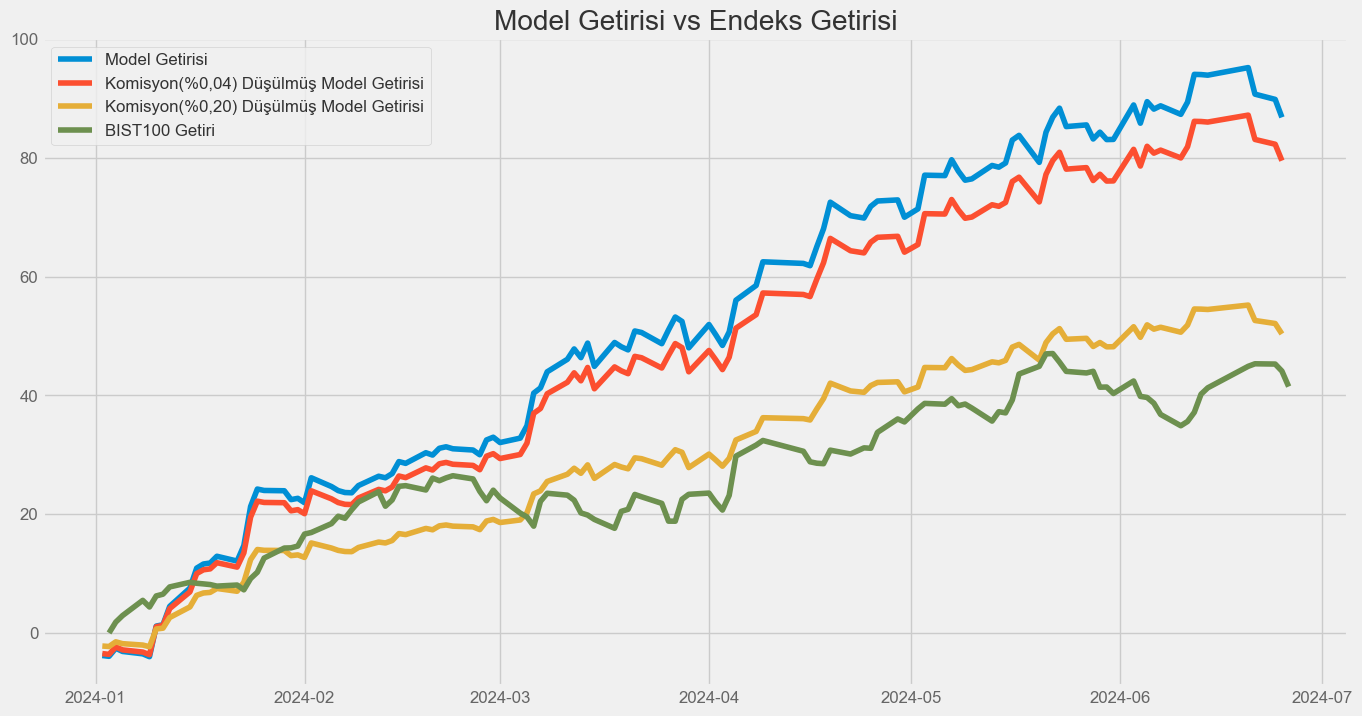

In [108]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("Model Getirisi vs Endeks Getirisi")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-1].cumsum().dropna(),label="Model Getirisi")
plt.plot(top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-1].cumsum().dropna(),label="Komisyon(%0,04) Düşülmüş Model Getirisi")
plt.plot(top_5_rows2.groupby('Date')["Gerçek"].mean().iloc[:-1].cumsum().dropna(),label="Komisyon(%0,20) Düşülmüş Model Getirisi")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'RAYSG'),
  Text(0, 1, 'VKFYO'),
  Text(0, 2, 'MEDTR'),
  Text(0, 3, 'GARFA'),
  Text(0, 4, 'MTRYO'),
  Text(0, 5, 'TGSAS'),
  Text(0, 6, 'MTRKS'),
  Text(0, 7, 'EUYO'),
  Text(0, 8, 'INVES'),
  Text(0, 9, 'COSMO'),
  Text(0, 10, 'KLRHO'),
  Text(0, 11, 'ATAGY'),
  Text(0, 12, 'ISKPL'),
  Text(0, 13, 'SUWEN'),
  Text(0, 14, 'GENIL'),
  Text(0, 15, 'ANSGR'),
  Text(0, 16, 'DERHL'),
  Text(0, 17, 'KZBGY'),
  Text(0, 18, 'AGESA'),
  Text(0, 19, 'BEGYO'),
  Text(0, 20, 'ERSU'),
  Text(0, 21, 'ANHYT'),
  Text(0, 22, 'BMSTL'),
  Text(0, 23, 'SKYMD'),
  Text(0, 24, 'AGROT'),
  Text(0, 25, 'RALYH'),
  Text(0, 26, 'PNSUT'),
  Text(0, 27, 'BJKAS'),
  Text(0, 28, 'TSGYO'),
  Text(0, 29, 'TRILC')])

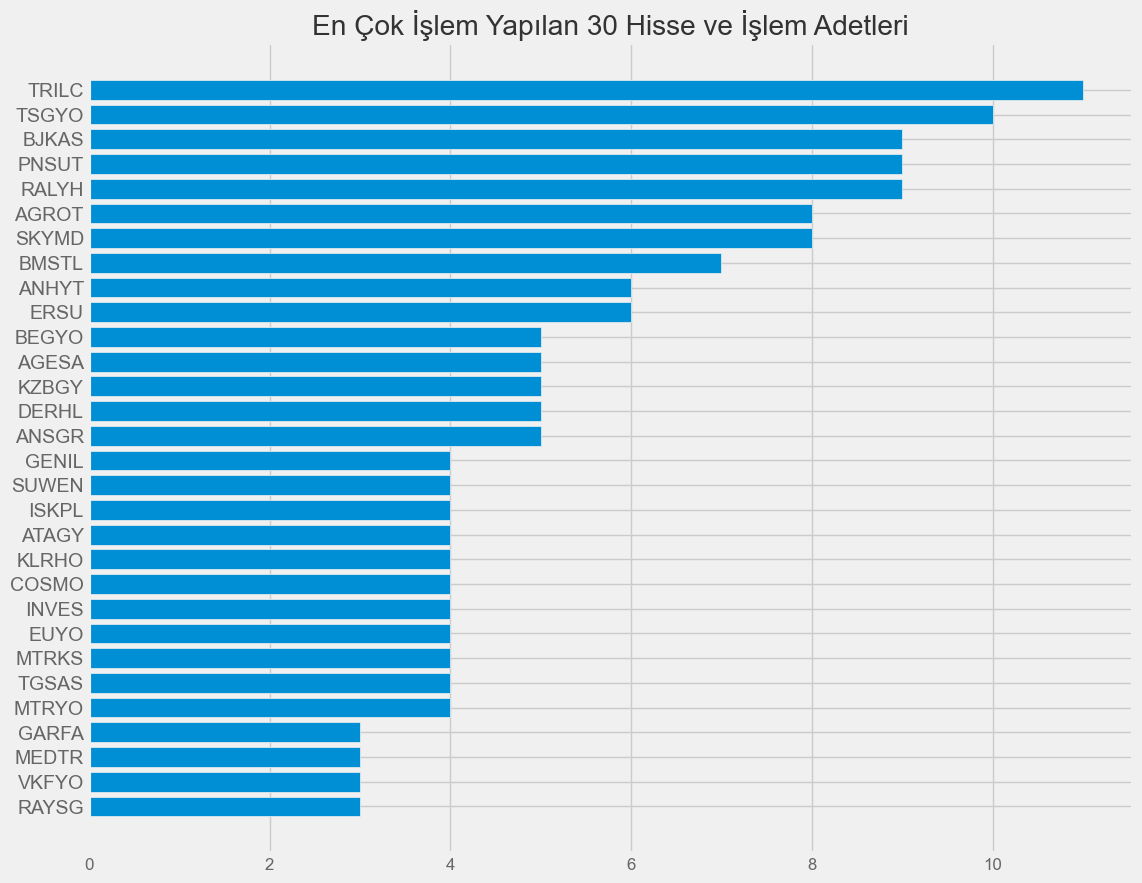

In [110]:
plt.figure(figsize=(12,10))
plt.title("En Çok İşlem Yapılan 30 Hisse ve İşlem Adetleri")
plt.barh(top_5_rows["Hisse"].value_counts().sort_values().tail(30).index,top_5_rows["Hisse"].value_counts().sort_values().tail(30).values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

In [112]:

returns=top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-1].cumsum().diff().dropna()
returns=returns/100
returns=pd.DataFrame(returns)
returns["Kar"]=np.where((returns>0),1,0)
returns
returns

,Gerçek,Kar
Date,,
2024-01-03,-0.001258,0
2024-01-04,0.012456,1
2024-01-05,-0.004936,0
2024-01-08,-0.003680,0
2024-01-09,-0.004416,0
...,...,...
2024-06-14,-0.000931,0
2024-06-20,0.011697,1
2024-06-21,-0.040961,0


In [113]:
endeks["Return"]=(endeks["Close"]/endeks["Close"].shift(1))-1
endeks

,Close,Getiri,Return,Kar
Date,,,,
2024-01-03,7412.04,0.000000,NaN,0
2024-01-04,7547.84,1.832154,0.018322,1
2024-01-05,7628.73,2.923487,0.010717,1
2024-01-08,7818.89,5.489042,0.024927,1
2024-01-09,7736.26,4.374234,-0.010568,0
...,...,...,...,...
2024-06-20,10739.94,44.898570,0.025653,1
2024-06-21,10771.36,45.322475,0.002926,1
2024-06-24,10767.85,45.275120,-0.000326,0


In [114]:
endeks["Kar"]=np.where((endeks["Return"]>0),1,0)


In [115]:
def ortalama_kazanma_serisi_uzunlugu(veri):
    kazanma_serileri = []  # Kazanma serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kazanma serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 1:  # Eğer 1 görürsek,
            current_series_length += 1  # Kazanma serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kazanma serisi bitmişse,
                kazanma_serileri.append(current_series_length)  # Kazanma serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kazanma serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kazanma serisi varsa,
        kazanma_serileri.append(current_series_length)  # Son kazanma serisini de listeye ekle.
    
    # Kazanma serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kazanma_serileri) / len(kazanma_serileri)
    
    return kazanma_serileri



# Fonksiyonu çağırarak ortalama kazanma serisi uzunluğunu bul
ortalama = ortalama_kazanma_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kaybetme serisi uzunluğu:", np.mean(ortalama))
print("Max kaybetme serisi uzunluğu:", np.max(ortalama))


Ortalama kaybetme serisi uzunluğu: 2.129032258064516
Max kaybetme serisi uzunluğu: 8


In [123]:
def ortalama_kaybetme_serisi_uzunlugu(veri):
    kaybetme_serileri = []  # Kaybetme serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kaybetme serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 0:  # Eğer 0 görürsek,
            current_series_length += 1  # Kaybetme serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kaybetme serisi bitmişse,
                kaybetme_serileri.append(current_series_length)  # Kaybetme serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kaybetme serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kaybetme serisi varsa,
        kaybetme_serileri.append(current_series_length)  # Son kaybetme serisini de listeye ekle.
    
    # Kaybetme serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kaybetme_serileri) / len(kaybetme_serileri)
    
    return kaybetme_serileri



# Fonksiyonu çağırarak ortalama kaybetme serisi uzunluğunu bul
ortalama = ortalama_kaybetme_serisi_uzunlugu(list(endeks["Kar"].values))
print("Ortalama kaybetme serisi uzunluğu:", np.mean(ortalama))
print("Max kaybetme serisi uzunluğu:", np.max(ortalama))


Ortalama kaybetme serisi uzunluğu: 2.1153846153846154
Max kaybetme serisi uzunluğu: 6


In [118]:
qs.reports.html(returns=returns["Gerçek"],benchmark=endeks["Return"])

In [122]:
returns[returns["Gerçek"]>0]

,Gerçek,Kar
Date,,
2024-01-04,0.012456,1
2024-01-10,0.047192,1
2024-01-11,0.002057,1
2024-01-12,0.028379,1
2024-01-15,0.028177,1
...,...,...
2024-06-05,0.033236,1
2024-06-07,0.005086,1
2024-06-11,0.018914,1


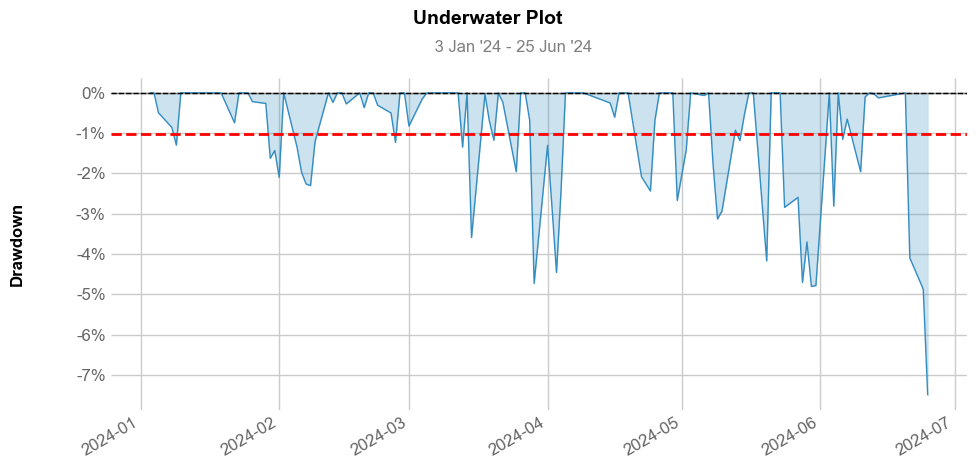

In [130]:
qs.plots.drawdown(returns=returns["Gerçek"])

In [129]:
endeks["Return"].std()*100

1.3497772978040756

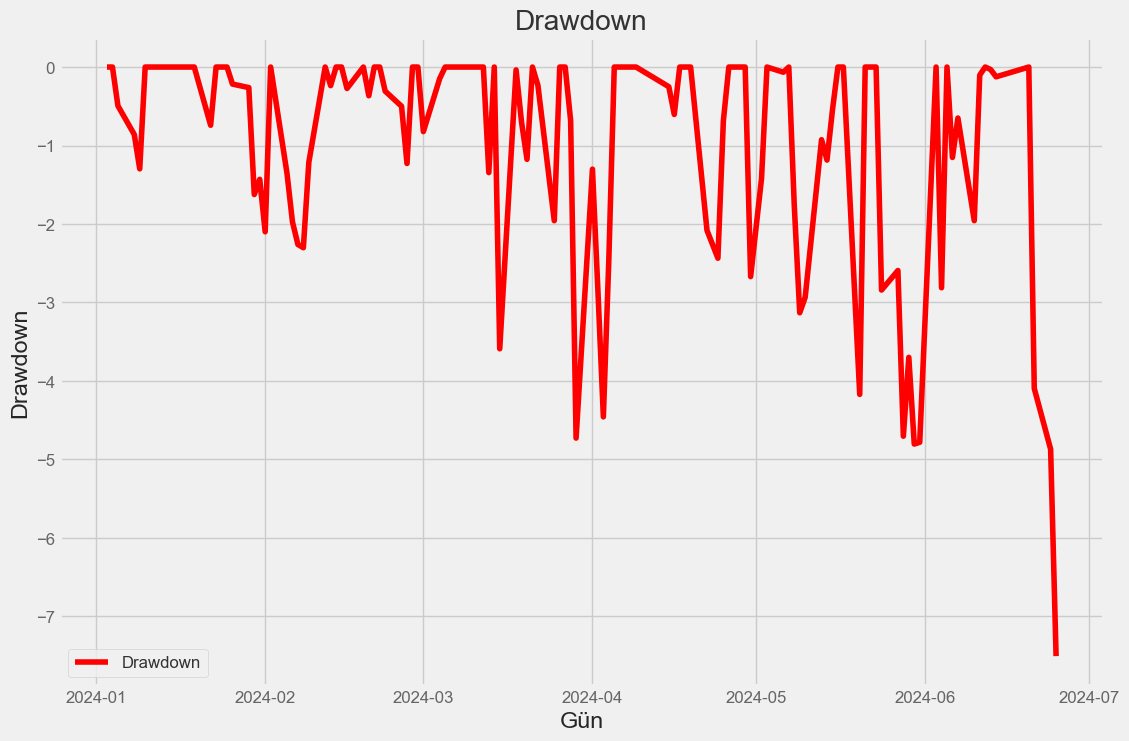

In [131]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert to DataFrame
cumulative_returns = np.cumprod(1+returns["Gerçek"])


def calculate_drawdowns(returns):
    peak = returns[0]
    drawdowns = [0]  # İlk değer 0, çünkü başlangıçta herhangi bir drawdown yok

    for ret in returns[1:]:
        if ret > peak:
            peak = ret
            drawdowns.append(0)  # Yeni zirve bulunduğunda drawdown sıfırlanır
        else:
            drawdowns.append(-100*((peak - ret) / peak))  # Drawdown hesaplanır
    
    return drawdowns

# Drawdown'ları hesapla
drawdowns = calculate_drawdowns(cumulative_returns)


# Grafik çizimi
plt.figure(figsize=(12, 8))
plt.plot(returns.index, drawdowns, label='Drawdown', color='red', linestyle='-')
plt.xlabel('Gün')
plt.ylabel('Drawdown')
plt.title('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

In [132]:
feature_importance = model.get_feature_importance(type='FeatureImportance')

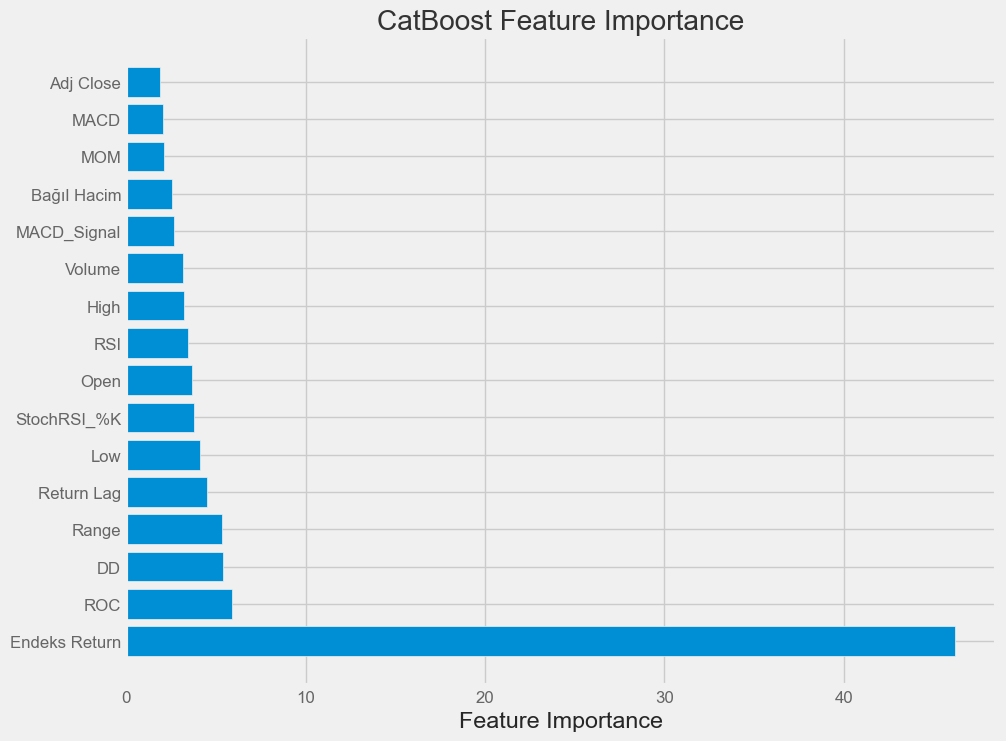

In [133]:
import catboost
feature_importance = model.get_feature_importance(type='FeatureImportance')
# Özellik isimlerini alın
feature_names = model.feature_names_

# Özellik önemlerini bir sözlükte saklayın
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Özellik önemlerine göre sıralayın
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Görselleştirme
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.yticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

In [107]:
combined_df["date"]=pd.to_datetime(combined_df.index)

In [118]:
top_5_rows.tail(6)

,Gerçek,Tahmin,Hisse,Tavan,Taban
Date,,,,,
2024-06-21,-6.718490,2.171693,POLTK,0,0
2024-06-21,-2.824268,1.222431,ENSRI,0,0
2024-06-21,4.125737,1.151065,OYLUM,0,0
2024-06-24,5.555556,0.706795,ADEL,0,0
2024-06-24,0.000000,0.599805,OYLUM,0,0
2024-06-24,0.000000,0.492875,DERHL,0,0


In [115]:
top_5_rows.merge(combined_df, on=['Date', 'Hisse'], how='left')

,Gerçek,Tahmin,Hisse,Tavan,Taban
Date,,,,,
2024-01-02,9.934259,0.914380,SANEL,0,0
2024-01-02,12.635792,0.717483,BAYRK,0,0
2024-01-02,-5.309735,0.684196,COSMO,0,0
2024-01-03,-2.439024,0.941762,SAMAT,0,0
2024-01-03,8.039216,0.786664,ZRGYO,0,0
...,...,...,...,...,...
2024-06-21,-2.824268,1.222431,ENSRI,0,0
2024-06-21,4.125737,1.151065,OYLUM,0,0
2024-06-24,5.555556,0.706795,ADEL,0,0


In [85]:
alışlar = []
satışlar=[]
indexler = combined_df['date'].unique()

for date in combined_df['date']:
    future_dates = indexler[indexler > date]
    if len(future_dates) >= 1:
        satış_tarihi = future_dates[0]
    else:
        satış_tarihi = pd.NaT
    satışlar.append(satış_tarihi)

for date in combined_df['date']:
    future_dates = indexler[indexler > date]
    if len(future_dates) >= 1:
        alış_tarihi = future_dates[0]
    else:
        alış_tarihi = pd.NaT
    alışlar.append(alış_tarihi)


combined_df['satış_tarihi'] = satışlar
combined_df['alış_tarihi'] = alışlar


In [94]:
combined_df['satış_tarihi'] = satışlar
combined_df['alış_tarihi'] = alışlar

In [95]:
combined_df["date"]=pd.to_datetime(combined_df.index)

In [101]:
top_5_rows1.index.map(combined_df.set_index(['satış_tarihi', 'Hisse'])['Open'])

Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       ...
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype='float64', name='Date', length=342)

In [98]:
top_5_rows1['Alış Fiyatı'] = top_5_rows1.set_index(['date', 'Hisse']).index.map(combined_df.set_index(['satış_tarihi', 'Hisse'])['Open'])
top_5_rows1['Satış Fiyatı'] = top_5_rows1.set_index(['date', 'Hisse']).index.map(combined_df.set_index(['satış_tarihi', 'Hisse'])['Adj Close'])

top_5_rows1

,Kar,Tahmin,Hisse,Tavan,Taban,Alış Tarihi,Satış Tarihi,alış_tarihi,Alış Fiyatı,Satış Fiyatı,Alış Tarihi,Satış Tarihi,Alış Tarihi,Satış Tarihi,date
Date,,,,,,,,,,,,,,,
2024-01-02,9.099284,0.914380,SANEL,0,0,2024-01-02,2024-01-03,2024-01-03,25.00,25.00,2024-01-02,2024-01-03,2024-01-02,2024-01-03,2024-01-02
2024-01-02,11.573754,0.717483,BAYRK,0,0,2024-01-02,2024-01-03,2024-01-03,16.94,16.80,2024-01-02,2024-01-03,2024-01-02,2024-01-03,2024-01-02
2024-01-02,-4.863451,0.684196,COSMO,0,0,2024-01-02,2024-01-03,2024-01-03,102.10,109.00,2024-01-02,2024-01-03,2024-01-02,2024-01-03,2024-01-02
2024-01-03,-2.234024,0.941762,SAMAT,0,0,2024-01-03,2024-01-04,2024-01-04,41.00,44.48,2024-01-03,2024-01-04,2024-01-03,2024-01-04,2024-01-03
2024-01-03,7.363520,0.786664,ZRGYO,0,0,2024-01-03,2024-01-04,2024-01-04,5.77,5.44,2024-01-03,2024-01-04,2024-01-03,2024-01-04,2024-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-21,-2.586888,1.222431,ENSRI,0,0,2024-06-21,2024-06-24,2024-06-24,19.70,19.12,2024-06-21,2024-06-24,2024-06-21,2024-06-24,2024-06-21
2024-06-21,3.778969,1.151065,OYLUM,0,0,2024-06-21,2024-06-24,2024-06-24,10.40,10.18,2024-06-21,2024-06-24,2024-06-21,2024-06-24,2024-06-21
2024-06-24,5.088611,0.706795,ADEL,0,0,2024-06-24,NaT,NaT,546.00,520.00,2024-06-24,NaT,2024-06-24,NaT,2024-06-24


In [99]:
top_5_rows1=top_5_rows1.rename(columns={"date":"Alış Tarihi","Gerçek":"Kar","satış_tarihi":"Satış Tarihi"})
top_5_rows1

,Kar,Tahmin,Hisse,Tavan,Taban,Alış Tarihi,Satış Tarihi,alış_tarihi,Alış Fiyatı,Satış Fiyatı,Alış Tarihi,Satış Tarihi,Alış Tarihi,Satış Tarihi,Alış Tarihi
Date,,,,,,,,,,,,,,,
2024-01-02,9.099284,0.914380,SANEL,0,0,2024-01-02,2024-01-03,2024-01-03,25.00,25.00,2024-01-02,2024-01-03,2024-01-02,2024-01-03,2024-01-02
2024-01-02,11.573754,0.717483,BAYRK,0,0,2024-01-02,2024-01-03,2024-01-03,16.94,16.80,2024-01-02,2024-01-03,2024-01-02,2024-01-03,2024-01-02
2024-01-02,-4.863451,0.684196,COSMO,0,0,2024-01-02,2024-01-03,2024-01-03,102.10,109.00,2024-01-02,2024-01-03,2024-01-02,2024-01-03,2024-01-02
2024-01-03,-2.234024,0.941762,SAMAT,0,0,2024-01-03,2024-01-04,2024-01-04,41.00,44.48,2024-01-03,2024-01-04,2024-01-03,2024-01-04,2024-01-03
2024-01-03,7.363520,0.786664,ZRGYO,0,0,2024-01-03,2024-01-04,2024-01-04,5.77,5.44,2024-01-03,2024-01-04,2024-01-03,2024-01-04,2024-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-21,-2.586888,1.222431,ENSRI,0,0,2024-06-21,2024-06-24,2024-06-24,19.70,19.12,2024-06-21,2024-06-24,2024-06-21,2024-06-24,2024-06-21
2024-06-21,3.778969,1.151065,OYLUM,0,0,2024-06-21,2024-06-24,2024-06-24,10.40,10.18,2024-06-21,2024-06-24,2024-06-21,2024-06-24,2024-06-21
2024-06-24,5.088611,0.706795,ADEL,0,0,2024-06-24,NaT,NaT,546.00,520.00,2024-06-24,NaT,2024-06-24,NaT,2024-06-24


In [73]:
top_5_rows1.to_excel("açılış.xlsx")

In [169]:
top_5_rows.sort_values(by="Gerçek",ascending=False).head(30)

,Gerçek,Tahmin,Hisse,Tavan,Taban
Date,,,,,
2024-06-26,20.779221,0.574896,EUHOL,0,0
2024-05-03,14.050558,0.530387,AKENR,0,0
2024-05-29,12.073491,0.672361,SKYMD,0,0
2024-03-06,10.517315,0.575648,MEGMT,0,0
2024-03-11,10.102900,0.722128,SAMAT,0,0
2024-03-21,10.032358,0.536744,JANTS,0,0
2024-03-26,10.000000,0.490339,YKSLN,0,0
2024-04-18,9.995903,0.501570,ANHYT,0,0
2024-06-03,9.977827,0.680265,PRZMA,0,0


In [200]:
top_5_rows.loc["2024-06-24":]

,Gerçek,Tahmin,Hisse,Tavan,Taban
Date,,,,,
2024-06-24,1.338583,0.509835,ISKPL,0,0
2024-06-24,-2.409639,0.506304,DERHL,0,0
2024-06-24,-1.573677,0.504769,GOZDE,0,0
2024-06-25,-3.634827,0.526159,DGNMO,0,0
2024-06-25,-1.785714,0.512317,RYSAS,0,0
2024-06-25,-3.657588,0.507641,ISKPL,0,0
2024-06-26,0.000000,0.621236,ENSRI,0,0
2024-06-26,3.472213,0.591622,SEKUR,0,0
2024-06-26,20.779221,0.574896,EUHOL,0,0


In [197]:
alımlar=['2024-03-01', '2024-03-06', '2024-03-07', '2024-04-09']
satışlar=['2024-03-01', '2024-03-06', '2024-03-07', '2024-04-09']

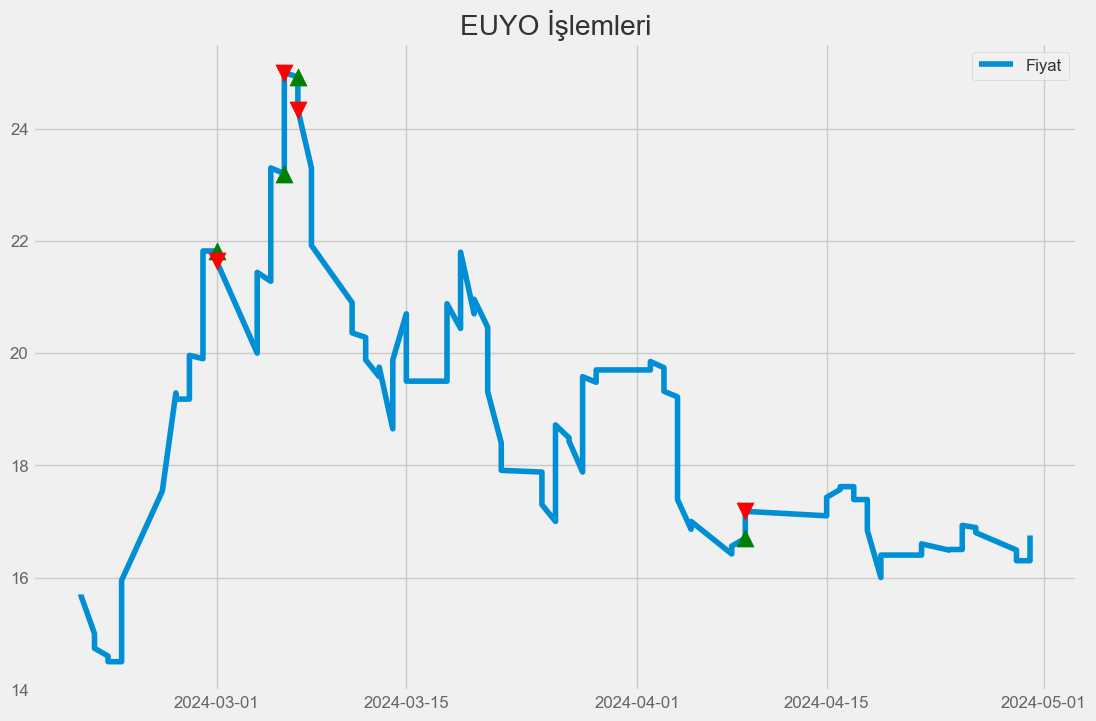

In [199]:
plt.figure(figsize=(12,8))
plt.title("EUYO İşlemleri")
plt.plot(pd.concat([combined_df[combined_df["Hisse"]=="EUYO"]["Open"].loc["2024-02-20":"2024-04-30"],combined_df[combined_df["Hisse"]=="EUYO"]["Adj Close"].loc["2024-02-20":"2024-04-30"]],axis=1).stack().reset_index(level=1, drop=True).to_frame('Value')
,label="Fiyat")
for alım in alımlar:
    plt.scatter(x=pd.to_datetime(alım),y=pd.concat([combined_df[combined_df["Hisse"]=="EUYO"]["Open"],combined_df[combined_df["Hisse"]=="EUYO"]["Adj Close"]],axis=1).stack().reset_index(level=1, drop=True).to_frame('Value').loc[alım].iloc[0],marker="^",s=150,color="green",zorder=3)
for satış in satışlar:
    plt.scatter(x=pd.to_datetime(satış),y=pd.concat([combined_df[combined_df["Hisse"]=="EUYO"]["Open"],combined_df[combined_df["Hisse"]=="EUYO"]["Adj Close"]],axis=1).stack().reset_index(level=1, drop=True).to_frame('Value').loc[satış].iloc[1],marker="v",s=150,color="red",zorder=3)
plt.legend()